<a href="https://colab.research.google.com/github/Caceres-Santamaria/proyecto-IA/blob/master/cancerCervical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://raw.githubusercontent.com/jmsr06/CancerCervical/master/fondo2.jpg" tite="Inteligencia Artificial en la medicina" style="width:1000px" alt="Algoritmos de Machine learning y Deep learning para la predicción de la realización biopsia"/>


<table align="left" border="1" style="font-size:100px">
<th>Nombre</th>
<th>Código</th>
<tr>
</tr>
<tr> 
<td>Jenny Marcela Santamaría</td>
<td>2171455</td>
</tr>
<tr>
<td>Nelson Alexis Cáceres</td>
<td>2171763</td>
</tr>
</table>



In [ ]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/proyecto-IA')
print(os.getcwd())

In [ ]:
!pip install imbalanced-learn
!pip install eli5

In [4]:
#@title  CARGAR LIBRERÍAS { display-mode: "form" }
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import * 
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib.pyplot import figure


from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import RFE

import seaborn as sns
#from sklearn.preprocessing import StandardScaler
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
#from imblearn.combine import SMOTETomek
#from imblearn.ensemble import BalancedBaggingClassifier
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## 1. Observación de los datos

In [5]:
d = pd.read_csv("data/risk_factors_cervical_cancer.csv") 
#d = pd.read_csv("data/cancer_cervical.csv")
print("tamaño: ",d.shape)
d.head()

tamaño:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


Faltan algunos valores denominados '?', E hicieron que toda la columna se convirtiera en un objeto. Para poder hacer los cálculos, tenemos que reemplazar '?' con NaN y cambiar el tipo de objeto a tipo numérico.

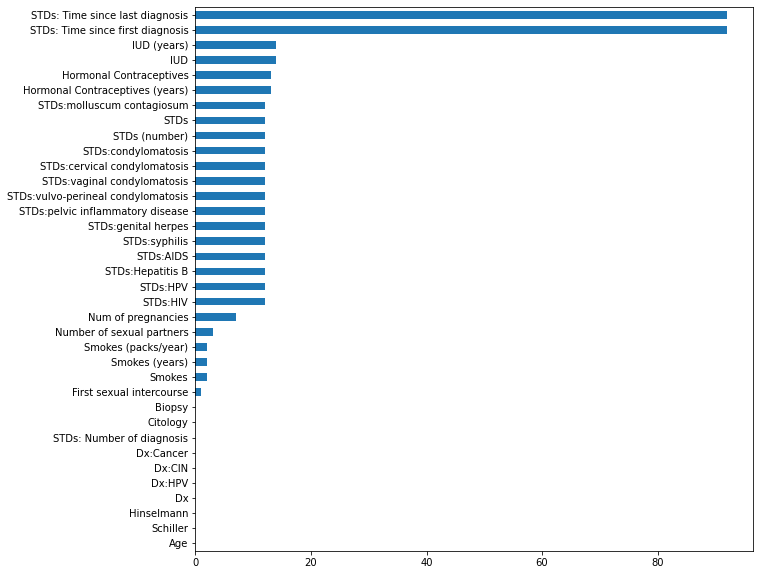

In [6]:
d= d.replace('?', np.nan)
plt.figure(figsize=(10,10))
np.round(d.isnull().sum()/d.shape[0]*100).sort_values().plot(kind='barh')

## 2. Procesamiento de Datos

Convertimos todas las columnas a tipo flotante

In [7]:
df = d
for i in df.columns:
  df[i]=df[i].astype(float)

<p align="justify">Observamos que tenemos algunas características que presentan muchos datos perdidos que no presentan una verdadera significancia, por lo tanto eliminamos éstas columnas de nuestro dataset</p>

In [8]:
df = df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)

<p align="justify">Anteriormente observamos que algunas características presentan datos perdidos representados como NAN, procedemos a llenar estos datos nulos con los predictores DecisionTreeClassifier y DecisionTreeRegressor, dependiento del tipo de dato que maneje la serie, si la serie tiene un tipo numérico se predice el dato perdido con el DecisionTreeRegressor, pero si por el contrario, la sierie es de tipo categórica (0 ó 1), predecimos estos datos con el DecisionTreeClassifier.</p>

In [9]:
dfc = df.copy()
dfc.columns=['Age', 'No_of_sex_partner', 'First_sexual_intercourse',\
            'No_pregnancies','Smokes',  'Smokes_yrs',  'Smokes_packs_yr',  'Hormonal_Contraceptives',\
            'Hormonal_Contraceptives_years','IUD', 'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis',\
            'STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis', 'STDs_vulvo_perineal_condylomatosis',\
            'STDs_syphilis', 'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes', 'STDs_molluscum_contagiosum',\
            'STDs_AIDS', 'STDs_HIV', 'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'Dx_Cancer', 'Dx_CIN', 'Dx_HPV',\
            'Dx', 'Hinselmann','Schiller' ,'Citology', 'Biopsy']
dfc=dfc.drop(dfc.index[dfc.Smokes.isnull()] | dfc.index[dfc.First_sexual_intercourse.isnull()])
x_caracteristicas=list(dfc.columns)
x_caracteristicas.remove('Biopsy')
x_caracteristicas_categoricas=['Smokes','Hormonal_Contraceptives','IUD','STDs','STDs_condylomatosis','STDs_cervical_condylomatosis',
                        'STDs_vaginal_condylomatosis','STDs_vulvo_perineal_condylomatosis','STDs_syphilis','STDs_pelvic_inflammatory_disease',
                        'STDs_genital_herpes','STDs_molluscum_contagiosum','STDs_AIDS','STDs_HIV','STDs_Hepatitis_B','STDs_HPV','Dx_Cancer','Dx_CIN',
                        'Dx_HPV','Dx']
x_caracteristicas_numericas=[i for i in x_caracteristicas if i not in x_caracteristicas_categoricas]

In [10]:
#@title Llenar los datos NAN con predictores { display-mode: "form" }
#Imputación de valor perdido del DIU
df_iud = dfc.copy()
x_caracteristicas_categoricas.remove('IUD')
for i in x_caracteristicas_categoricas:
    df_iud[i]=df_iud[i].fillna(df_iud[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_iud[i]=df_iud[i].fillna(df_iud[i].median())
#df_iud=df_iud.astype('float')
df_iud[x_caracteristicas_categoricas]=df_iud[x_caracteristicas_categoricas].replace(0,'no')
df_iud[x_caracteristicas_categoricas]=df_iud[x_caracteristicas_categoricas].replace(1,'yes')
df_iud=pd.get_dummies(df_iud)
train_iud=df_iud[df_iud.IUD.isnull()==False]
test_iud=df_iud[df_iud.IUD.isnull()]
train_iud_x=train_iud.drop('IUD',axis=1)
train_iud_y=train_iud['IUD']
test_iud_x=test_iud.drop('IUD',axis=1)
test_iud_y=test_iud['IUD']
dt=DecisionTreeClassifier()
iud_model=dt.fit(train_iud_x,train_iud_y)
test_iud['IUD']=iud_model.predict(test_iud_x)
iud_complete=pd.concat([train_iud,test_iud],axis=0)
df_impute=dfc.copy()
df_impute['IUD']=iud_complete['IUD'].sort_index()

#IUD_yesars (porque si UID es 0, UID_years también será cero)
x_caracteristicas_numericas.remove('IUD_years')
df_impute['IUD_years']=df_impute['IUD_years'].fillna(0)

#Hormonal_Contraceptives
df_hor=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('Hormonal_Contraceptives')
for i in x_caracteristicas_categoricas:
    df_hor[i]=df_hor[i].fillna(df_hor[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_hor[i]=df_hor[i].fillna(df_hor[i].median())
#df_hor=df_hor.astype('float')
df_hor[x_caracteristicas_categoricas]=df_hor[x_caracteristicas_categoricas].replace(0,'no')
df_hor[x_caracteristicas_categoricas]=df_hor[x_caracteristicas_categoricas].replace(1,'yes')
df_hor=pd.get_dummies(df_hor)
train_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()==False]
test_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()]
train_hor_x=train_hor.drop('Hormonal_Contraceptives',axis=1)
train_hor_y=train_hor['Hormonal_Contraceptives']
test_hor_x=test_hor.drop('Hormonal_Contraceptives',axis=1)
test_hor_y=test_hor['Hormonal_Contraceptives']
dt=DecisionTreeClassifier()
hor_model=dt.fit(train_hor_x,train_hor_y)
test_hor['Hormonal_Contraceptives']=hor_model.predict(test_hor_x)
hor_complete=pd.concat([train_hor,test_hor],axis=0)
df_impute['Hormonal_Contraceptives']=hor_complete['Hormonal_Contraceptives'].sort_index()

#Hormonal_Contraceptives_years
df_hor_y=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('Hormonal_Contraceptives_years')
for i in x_caracteristicas_categoricas:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].median())
#df_hor_y=df_hor_y.astype('float')
df_hor_y[x_caracteristicas_categoricas]=df_hor_y[x_caracteristicas_categoricas].replace(0,'no')
df_hor_y[x_caracteristicas_categoricas]=df_hor_y[x_caracteristicas_categoricas].replace(1,'yes')
df_hor_y=pd.get_dummies(df_hor_y)
train_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()==False]
test_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()]
train_hor_yrs_x=train_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
train_hor_yrs_y=train_hor_yrs['Hormonal_Contraceptives_years']
test_hor_yrs_x=test_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
test_hor_yrs_y=test_hor_yrs['Hormonal_Contraceptives_years']
dt=DecisionTreeRegressor()
hor_yrs_model=dt.fit(train_hor_yrs_x,train_hor_yrs_y)
test_hor_yrs['Hormonal_Contraceptives_years']=hor_yrs_model.predict(test_hor_yrs_x)
hor_yrs_complete=pd.concat([train_hor_yrs,test_hor_yrs],axis=0)
df_impute['Hormonal_Contraceptives_years']=hor_yrs_complete['Hormonal_Contraceptives_years'].sort_index()

#STDs
df_std=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs')
for i in x_caracteristicas_categoricas:
    df_std[i]=df_std[i].fillna(df_std[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std[i]=df_std[i].fillna(df_std[i].median()) 
#df_std=df_std.astype('float')
df_std[x_caracteristicas_categoricas]=df_std[x_caracteristicas_categoricas].replace(0,'no')
df_std[x_caracteristicas_categoricas]=df_std[x_caracteristicas_categoricas].replace(1,'yes')
df_std=pd.get_dummies(df_std)
train_std=df_std[df_std.STDs.isnull()==False]
test_std=df_std[df_std.STDs.isnull()]
train_std_x=train_std.drop('STDs',axis=1)
train_std_y=train_std['STDs']
test_std_x=test_std.drop('STDs',axis=1)
test_std_y=test_std['STDs']
dt=DecisionTreeClassifier()
std_model=dt.fit(train_std_x,train_std_y)
test_std['STDs']=std_model.predict(test_std_x)
std_complete=pd.concat([train_std,test_std],axis=0)
df_impute['STDs']=std_complete['STDs'].sort_index()

#STDs_number
df_std_num=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('STDs_number')
for i in x_caracteristicas_categoricas:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].median())
#df_std_num=df_std_num.astype('float')
df_std_num[x_caracteristicas_categoricas]=df_std_num[x_caracteristicas_categoricas].replace(0,'no')
df_std_num[x_caracteristicas_categoricas]=df_std_num[x_caracteristicas_categoricas].replace(1,'yes')
df_std_num=pd.get_dummies(df_std_num)
train_std_num=df_std_num[df_std_num.STDs_number.isnull()==False]
test_std_num=df_std_num[df_std_num.STDs_number.isnull()]
train_std_num_x=train_std_num.drop('STDs_number',axis=1)
train_std_num_y=train_std_num['STDs_number']
test_std_num_x=test_std_num.drop('STDs_number',axis=1)
test_std_num_y=test_std_num['STDs_number']
dt=DecisionTreeRegressor()
std_model_num=dt.fit(train_std_num_x,train_std_num_y)
test_std_num['STDs_number']=std_model_num.predict(test_std_num_x)
std_num_complete=pd.concat([train_std_num,test_std_num],axis=0)
df_impute['STDs_number']=std_num_complete['STDs_number'].sort_index()

#STDs_condylomatosis
df_std_con=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].median())
#df_std_con=df_std_con.astype('float')
df_std_con[x_caracteristicas_categoricas]=df_std_con[x_caracteristicas_categoricas].replace(0,'no')
df_std_con[x_caracteristicas_categoricas]=df_std_con[x_caracteristicas_categoricas].replace(1,'yes')
df_std_con=pd.get_dummies(df_std_con)
train_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()==False]
test_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()]
train_std_con_x=train_std_con.drop('STDs_condylomatosis',axis=1)
train_std_con_y=train_std_con['STDs_condylomatosis']
test_std_con_x=test_std_con.drop('STDs_condylomatosis',axis=1)
test_std_con_y=test_std_con['STDs_condylomatosis']
dt=DecisionTreeClassifier()
std_model_con=dt.fit(train_std_con_x,train_std_con_y)
test_std_con['STDs_condylomatosis']=std_model_con.predict(test_std_con_x)
std_con_complete=pd.concat([train_std_con,test_std_con],axis=0)
df_impute['STDs_condylomatosis']=std_con_complete['STDs_condylomatosis'].sort_index()

#STDs_cervical_condylomatosis
df_std_cerv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_cervical_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].median())
#df_std_cerv=df_std_cerv.astype('float')
df_std_cerv[x_caracteristicas_categoricas]=df_std_cerv[x_caracteristicas_categoricas].replace(0,'no')
df_std_cerv[x_caracteristicas_categoricas]=df_std_cerv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_cerv=pd.get_dummies(df_std_cerv)
train_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()==False]
test_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()]
train_std_cerv_x=train_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
train_std_cerv_y=train_std_cerv['STDs_cervical_condylomatosis']
test_std_cerv_x=test_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
test_std_cerv_y=test_std_cerv['STDs_cervical_condylomatosis']
dt=DecisionTreeClassifier()
std_model_cerv=dt.fit(train_std_cerv_x,train_std_cerv_y)
test_std_cerv['STDs_cervical_condylomatosis']=std_model_cerv.predict(test_std_cerv_x)
std_cerv_complete=pd.concat([train_std_cerv,test_std_cerv],axis=0)
df_impute['STDs_cervical_condylomatosis']=std_cerv_complete['STDs_cervical_condylomatosis'].sort_index()

#STDs_vaginal_condylomatosis
df_std_vagi=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_vaginal_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].median())
#df_std_vagi=df_std_vagi.astype('float')
df_std_vagi[x_caracteristicas_categoricas]=df_std_vagi[x_caracteristicas_categoricas].replace(0,'no')
df_std_vagi[x_caracteristicas_categoricas]=df_std_vagi[x_caracteristicas_categoricas].replace(1,'yes')
df_std_vagi=pd.get_dummies(df_std_vagi)
train_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()==False]
test_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()]
train_std_vagi_x=train_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
train_std_vagi_y=train_std_vagi['STDs_vaginal_condylomatosis']
test_std_vagi_x=test_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
test_std_vagi_y=test_std_vagi['STDs_vaginal_condylomatosis']
dt=DecisionTreeClassifier()
std_model_vagi=dt.fit(train_std_vagi_x,train_std_vagi_y)
test_std_vagi['STDs_vaginal_condylomatosis']=std_model_vagi.predict(test_std_vagi_x)
std_vagi_complete=pd.concat([train_std_vagi,test_std_vagi],axis=0)
df_impute['STDs_vaginal_condylomatosis']=std_vagi_complete['STDs_vaginal_condylomatosis'].sort_index()

#STDs_vulvo_perineal_condylomatosis
df_std_peri=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_vulvo_perineal_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].median())
#df_std_peri=df_std_peri.astype('float')
df_std_peri[x_caracteristicas_categoricas]=df_std_peri[x_caracteristicas_categoricas].replace(0,'no')
df_std_peri[x_caracteristicas_categoricas]=df_std_peri[x_caracteristicas_categoricas].replace(1,'yes')
df_std_peri=pd.get_dummies(df_std_peri)
train_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()==False]
test_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()]
train_std_peri_x=train_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
train_std_peri_y=train_std_peri['STDs_vulvo_perineal_condylomatosis']
test_std_peri_x=test_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
test_std_peri_y=test_std_peri['STDs_vulvo_perineal_condylomatosis']
dt=DecisionTreeClassifier()
std_model_peri=dt.fit(train_std_peri_x,train_std_peri_y)
test_std_peri['STDs_vulvo_perineal_condylomatosis']=std_model_peri.predict(test_std_peri_x)
std_peri_complete=pd.concat([train_std_peri,test_std_peri],axis=0)
df_impute['STDs_vulvo_perineal_condylomatosis']=std_peri_complete['STDs_vulvo_perineal_condylomatosis'].sort_index()

#STDs_syphilis
df_std_syp=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_syphilis')
for i in x_caracteristicas_categoricas:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].median())
#df_std_syp=df_std_syp.astype('float')
df_std_syp[x_caracteristicas_categoricas]=df_std_syp[x_caracteristicas_categoricas].replace(0,'no')
df_std_syp[x_caracteristicas_categoricas]=df_std_syp[x_caracteristicas_categoricas].replace(1,'yes')
df_std_syp=pd.get_dummies(df_std_syp)
train_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()==False]
test_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()]
train_std_syp_x=train_std_syp.drop('STDs_syphilis',axis=1)
train_std_syp_y=train_std_syp['STDs_syphilis']
test_std_syp_x=test_std_syp.drop('STDs_syphilis',axis=1)
test_std_syp_y=test_std_syp['STDs_syphilis']
dt=DecisionTreeClassifier()
std_model_syp=dt.fit(train_std_syp_x,train_std_syp_y)
test_std_syp['STDs_syphilis']=std_model_syp.predict(test_std_syp_x)
std_syp_complete=pd.concat([train_std_syp,test_std_syp],axis=0)
df_impute['STDs_syphilis']=std_syp_complete['STDs_syphilis'].sort_index()

#STDs_pelvic_inflammatory_disease
df_std_pelv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_pelvic_inflammatory_disease')
for i in x_caracteristicas_categoricas:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].median())                          
#df_std_pelv=df_std_pelv.astype('float')
df_std_pelv[x_caracteristicas_categoricas]=df_std_pelv[x_caracteristicas_categoricas].replace(0,'no')
df_std_pelv[x_caracteristicas_categoricas]=df_std_pelv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_pelv=pd.get_dummies(df_std_pelv)
train_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()==False]
test_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()]
train_std_pelv_x=train_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
train_std_pelv_y=train_std_pelv['STDs_pelvic_inflammatory_disease']
test_std_pelv_x=test_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
test_std_pelv_y=test_std_pelv['STDs_pelvic_inflammatory_disease']
dt=DecisionTreeClassifier()
std_model_pelv=dt.fit(train_std_pelv_x,train_std_pelv_y)
test_std_pelv['STDs_pelvic_inflammatory_disease']=std_model_pelv.predict(test_std_pelv_x)
std_pelv_complete=pd.concat([train_std_pelv,test_std_pelv],axis=0)
df_impute['STDs_pelvic_inflammatory_disease']=std_pelv_complete['STDs_pelvic_inflammatory_disease'].sort_index()

#STDs_genital_herpes
df_std_geni=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_genital_herpes')
for i in x_caracteristicas_categoricas:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].median())
#df_std_geni=df_std_geni.astype('float')
df_std_geni[x_caracteristicas_categoricas]=df_std_geni[x_caracteristicas_categoricas].replace(0,'no')
df_std_geni[x_caracteristicas_categoricas]=df_std_geni[x_caracteristicas_categoricas].replace(1,'yes')
df_std_geni=pd.get_dummies(df_std_geni)
train_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()==False]
test_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()]
train_std_geni_x=train_std_geni.drop('STDs_genital_herpes',axis=1)
train_std_geni_y=train_std_geni['STDs_genital_herpes']
test_std_geni_x=test_std_geni.drop('STDs_genital_herpes',axis=1)
test_std_geni_y=test_std_geni['STDs_genital_herpes']
dt=DecisionTreeClassifier()
std_model_geni=dt.fit(train_std_geni_x,train_std_geni_y)
test_std_geni['STDs_genital_herpes']=std_model_geni.predict(test_std_geni_x)
std_geni_complete=pd.concat([train_std_geni,test_std_geni],axis=0)
df_impute['STDs_genital_herpes']=std_geni_complete['STDs_genital_herpes'].sort_index()

#STDs_molluscum_contagiosum
df_std_mollu=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_molluscum_contagiosum')
for i in x_caracteristicas_categoricas:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].median())
#df_std_mollu=df_std_mollu.astype('float')
df_std_mollu[x_caracteristicas_categoricas]=df_std_mollu[x_caracteristicas_categoricas].replace(0,'no')
df_std_mollu[x_caracteristicas_categoricas]=df_std_mollu[x_caracteristicas_categoricas].replace(1,'yes')
df_std_mollu=pd.get_dummies(df_std_mollu)
train_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()==False]
test_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()]
train_std_mollu_x=train_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
train_std_mollu_y=train_std_mollu['STDs_molluscum_contagiosum']
test_std_mollu_x=test_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
test_std_mollu_y=test_std_mollu['STDs_molluscum_contagiosum']
dt=DecisionTreeClassifier()
std_model_mollu=dt.fit(train_std_mollu_x,train_std_mollu_y)
test_std_mollu['STDs_molluscum_contagiosum']=std_model_mollu.predict(test_std_mollu_x)
std_mollu_complete=pd.concat([train_std_mollu,test_std_mollu],axis=0)
df_impute['STDs_molluscum_contagiosum']=std_mollu_complete['STDs_molluscum_contagiosum'].sort_index()

#STDs_AIDS
df_std_aids=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_AIDS')
for i in x_caracteristicas_categoricas:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].median())
#df_std_aids=df_std_aids.astype('float')
df_std_aids[x_caracteristicas_categoricas]=df_std_aids[x_caracteristicas_categoricas].replace(0,'no')
df_std_aids[x_caracteristicas_categoricas]=df_std_aids[x_caracteristicas_categoricas].replace(1,'yes')
df_std_aids=pd.get_dummies(df_std_aids)
train_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()==False]
test_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()]
train_std_aids_x=train_std_aids.drop('STDs_AIDS',axis=1)
train_std_aids_y=train_std_aids['STDs_AIDS']
test_std_aids_x=test_std_aids.drop('STDs_AIDS',axis=1)
test_std_aids_y=test_std_aids['STDs_AIDS']
dt=DecisionTreeClassifier()
std_model_aids=dt.fit(train_std_aids_x,train_std_aids_y)
test_std_aids['STDs_AIDS']=std_model_aids.predict(test_std_aids_x)
std_aids_complete=pd.concat([train_std_aids,test_std_aids],axis=0)
df_impute['STDs_AIDS']=std_aids_complete['STDs_AIDS'].sort_index()

#STDs_HIV
df_std_hiv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_HIV')
for i in x_caracteristicas_categoricas:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].median())
#df_std_hiv=df_std_hiv.astype('float')
df_std_hiv[x_caracteristicas_categoricas]=df_std_hiv[x_caracteristicas_categoricas].replace(0,'no')
df_std_hiv[x_caracteristicas_categoricas]=df_std_hiv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hiv=pd.get_dummies(df_std_hiv)
train_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()==False]
test_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()]
train_std_hiv_x=train_std_hiv.drop('STDs_HIV',axis=1)
train_std_hiv_y=train_std_hiv['STDs_HIV']
test_std_hiv_x=test_std_hiv.drop('STDs_HIV',axis=1)
test_std_hiv_y=test_std_hiv['STDs_HIV']
dt=DecisionTreeClassifier()
std_model_hiv=dt.fit(train_std_hiv_x,train_std_hiv_y)
test_std_hiv['STDs_HIV']=std_model_hiv.predict(test_std_hiv_x)
std_hiv_complete=pd.concat([train_std_hiv,test_std_hiv],axis=0)
df_impute['STDs_HIV']=std_hiv_complete['STDs_HIV'].sort_index()

#STDs_Hepatitis_B
df_std_hepa=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_Hepatitis_B')
for i in x_caracteristicas_categoricas:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].median())
#df_std_hepa=df_std_hepa.astype('float')
df_std_hepa[x_caracteristicas_categoricas]=df_std_hepa[x_caracteristicas_categoricas].replace(0,'no')
df_std_hepa[x_caracteristicas_categoricas]=df_std_hepa[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hepa=pd.get_dummies(df_std_hepa)
train_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()==False]
test_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()]
train_std_hepa_x=train_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
train_std_hepa_y=train_std_hepa['STDs_Hepatitis_B']
test_std_hepa_x=test_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
test_std_hepa_y=test_std_hepa['STDs_Hepatitis_B']
dt=DecisionTreeClassifier()
std_model_hepa=dt.fit(train_std_hepa_x,train_std_hepa_y)
test_std_hepa['STDs_Hepatitis_B']=std_model_hepa.predict(test_std_hepa_x)
std_hepa_complete=pd.concat([train_std_hepa,test_std_hepa],axis=0)
df_impute['STDs_Hepatitis_B']=std_hepa_complete['STDs_Hepatitis_B'].sort_index()

#STDs_HPV
df_std_hpv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_HPV')
for i in x_caracteristicas_categoricas:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].median())
#df_std_hpv=df_std_hpv.astype('float')
df_std_hpv[x_caracteristicas_categoricas]=df_std_hpv[x_caracteristicas_categoricas].replace(0,'no')
df_std_hpv[x_caracteristicas_categoricas]=df_std_hpv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hpv=pd.get_dummies(df_std_hpv)
train_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()==False]
test_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()]
train_std_hpv_x=train_std_hpv.drop(['STDs_HPV'],axis=1)
train_std_hpv_y=train_std_hpv['STDs_HPV']
test_std_hpv_x=test_std_hpv.drop(['STDs_HPV'],axis=1)
test_std_hpv_y=test_std_hpv['STDs_HPV']
dt=DecisionTreeClassifier()
std_model_hpv=dt.fit(train_std_hpv_x,train_std_hpv_y)
test_std_hpv['STDs_HPV']=std_model_hpv.predict(test_std_hpv_x)
std_hpv_complete=pd.concat([train_std_hpv,test_std_hpv],axis=0)
df_impute['STDs_HPV']=std_hpv_complete['STDs_HPV'].sort_index()

#No_pregnancies
df_no_preg=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('No_pregnancies')
for i in x_caracteristicas_numericas:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].median())
for i in x_caracteristicas_categoricas:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].mode()[0])
#df_no_preg=df_no_preg.astype('float')
df_no_preg[x_caracteristicas_categoricas]=df_no_preg[x_caracteristicas_categoricas].replace(0,'no')
df_no_preg[x_caracteristicas_categoricas]=df_no_preg[x_caracteristicas_categoricas].replace(1,'yes')
df_no_preg=pd.get_dummies(df_no_preg)
train_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()==False]
test_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()]
train_no_preg_x=train_no_preg.drop(['No_pregnancies'],axis=1)
train_no_preg_y=train_no_preg['No_pregnancies']
test_no_preg_x=test_no_preg.drop(['No_pregnancies'],axis=1)
test_no_preg_y=test_no_preg['No_pregnancies']
dt=DecisionTreeRegressor()
model_no_preg=dt.fit(train_no_preg_x,train_no_preg_y)
test_no_preg['No_pregnancies']=model_no_preg.predict(test_no_preg_x)
no_preg_complete=pd.concat([train_no_preg,test_no_preg],axis=0)
df_impute['No_pregnancies']=no_preg_complete['No_pregnancies'].sort_index()

#No_of_sex_partner
df_no_sexptnr=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('No_of_sex_partner')
for i in x_caracteristicas_numericas:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].median())
for i in x_caracteristicas_categoricas:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].mode()[0])
#df_no_sexptnr=df_no_sexptnr.astype('float')
df_no_sexptnr[x_caracteristicas_categoricas]=df_no_sexptnr[x_caracteristicas_categoricas].replace(0,'no')
df_no_sexptnr[x_caracteristicas_categoricas]=df_no_sexptnr[x_caracteristicas_categoricas].replace(1,'yes')
df_no_sexptnr=pd.get_dummies(df_no_sexptnr)
train_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()==False]
test_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()]
train_no_sexptnr_x=train_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
train_no_sexptnr_y=train_no_sexptnr['No_of_sex_partner']
test_no_sexptnr_x=test_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
test_no_sexptnr_y=test_no_sexptnr['No_of_sex_partner']
dt=DecisionTreeRegressor()
model_no_sexptnr=dt.fit(train_no_sexptnr_x,train_no_sexptnr_y)
test_no_sexptnr['No_of_sex_partner']=model_no_sexptnr.predict(test_no_sexptnr_x)
no_sexptnr_complete=pd.concat([train_no_sexptnr,test_no_sexptnr],axis=0)
df_impute['No_of_sex_partner']=no_sexptnr_complete['No_of_sex_partner'].sort_index()

In [11]:
df_impute.isnull().sum()

Age                                   0
No_of_sex_partner                     0
First_sexual_intercourse              0
No_pregnancies                        0
Smokes                                0
Smokes_yrs                            0
Smokes_packs_yr                       0
Hormonal_Contraceptives               0
Hormonal_Contraceptives_years         0
IUD                                   0
IUD_years                             0
STDs                                  0
STDs_number                           0
STDs_condylomatosis                   0
STDs_cervical_condylomatosis          0
STDs_vaginal_condylomatosis           0
STDs_vulvo_perineal_condylomatosis    0
STDs_syphilis                         0
STDs_pelvic_inflammatory_disease      0
STDs_genital_herpes                   0
STDs_molluscum_contagiosum            0
STDs_AIDS                             0
STDs_HIV                              0
STDs_Hepatitis_B                      0
STDs_HPV                              0


Guardamos el dataset donde rellenamos todos los valores nulos

In [ ]:
df_impute.to_csv('data/df_imputation.csv')

## 3. Visualización de los datos

Importamos el dataset que se modificó, es decir, el dataset sin datos nulos

In [12]:
df_data = pd.read_csv('data/df_imputation.csv', index_col=0)

Observamos una descripción de la características numéricas del dataset

In [13]:
df_data[['Age','No_pregnancies', 'No_of_sex_partner','First_sexual_intercourse','Smokes_yrs','Smokes_packs_yr','STDs_No_of_diagnosis', 'Hormonal_Contraceptives_years', 'IUD_years', 'STDs_number']].describe()

,Age,No_pregnancies,No_of_sex_partner,First_sexual_intercourse,Smokes_yrs,Smokes_packs_yr,STDs_No_of_diagnosis,Hormonal_Contraceptives_years,IUD_years,STDs_number
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,26.812649,2.274463,2.507757,16.996420,1.216784,0.450366,0.084726,2.375990,0.445668,0.151551
std,8.529209,1.445495,1.587436,2.812965,4.090836,2.228754,0.295293,3.865077,1.823738,0.521638
min,13.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,2.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,2.000000,17.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
75%,32.000000,3.000000,3.000000,18.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,84.000000,11.000000,28.000000,32.000000,37.000000,37.000000,3.000000,30.000000,19.000000,4.000000


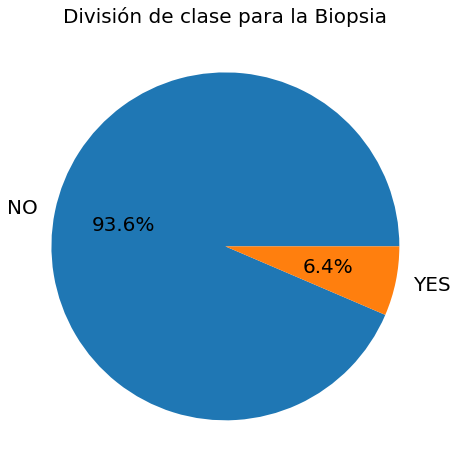

In [ ]:
#@title Porcentaje de biopsia { display-mode: "form" }

impute = df_data.copy()
impute=df_data.astype('float')

plt.figure(figsize = (12,8))
plt.pie(impute['Biopsy'].value_counts(), labels = ['NO', 'YES'], autopct = '%1.1f%%', labeldistance=1.1, textprops = {'fontsize': 20})
plt.title('División de clase para la Biopsia', fontsize=20)
plt.show()

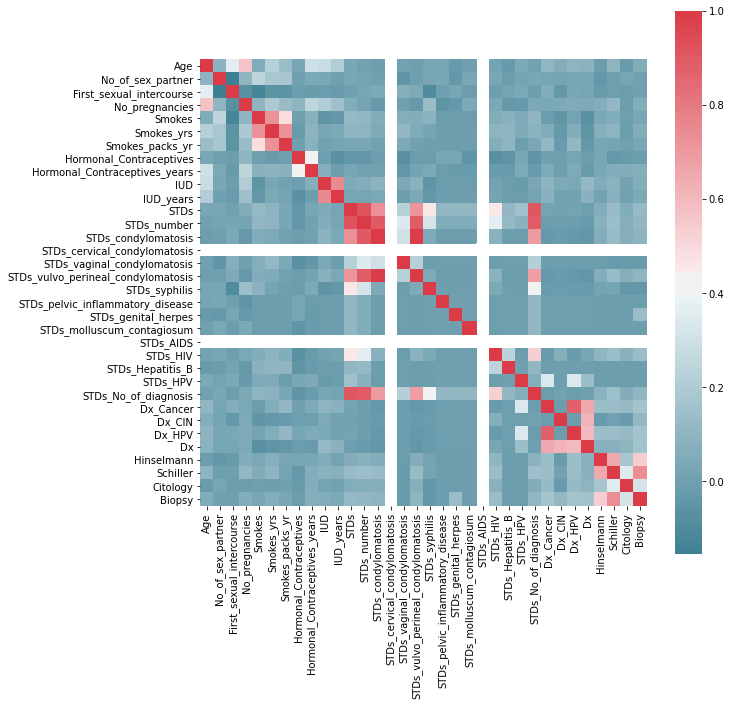

In [ ]:
#@title Correlación de los datos { display-mode: "form" }
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
corr = df_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

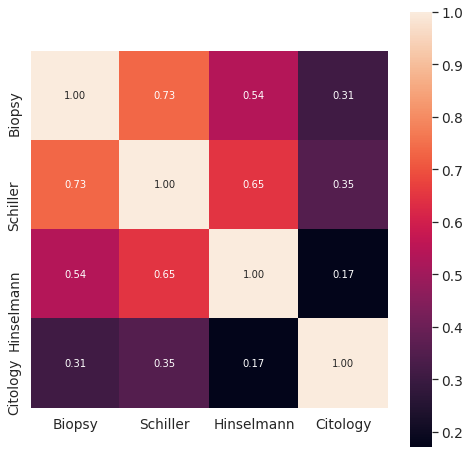

In [ ]:
#@title Datos más correlacionados con Biopsia { display-mode: "form" }
k = 4 #number of variables for heatmap
cols = corr.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df_data[cols].values.T)

plt.figure(figsize=(8,8)) 

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

## 4. División de las características y la clase

<p align="justify">Permutamos nuestro dataframe y porteriormente separamos las características de las clases y vemos la distribución de las etiquetas</p>  

In [14]:
#@title Funciones { display-mode: "form" }
def r_model(model,nombre,xtrain,ytrain,xtest,ytest):
  mod = {}
  modelo = model
  modelo.fit(xtrain,ytrain)
  ypred = modelo.predict(xtest)
  mod['Modelo'] = nombre
  mod['Train_Score'] = modelo.score(xtrain,ytrain)
  mod['Test_Score'] = modelo.score(xtest,ytest)
  mod['Test_accuracy'] = accuracy_score(ytest,ypred)
  mod['f1score'] = f1_score(ytest,ypred)
  reca = recall_score(ytest, ypred, average=None)
  mod['recall-0'] = reca[0]
  mod['recall-1'] = reca[1]
  prec = precision_score(ytest, ypred, average=None)
  mod['precision-0'] = prec[0]
  mod['precision-1'] = prec[1]
  #modelo.predict_proba(xtest)
  mod['roc_auc'] = roc_auc_score(ytest,ypred)
  return mod, ypred

def run_model_MC(est, xtrain, xtest, ytrain, ytest,kfold=10):
  est.fit(xtrain,ytrain)
  ypredict = est.predict(xtest)
  score=cross_val_score(est,xtest,ytest,cv=KFold(kfold,shuffle=True),scoring=make_scorer(accuracy_score))
  return est, ypredict, np.mean(score)

def matriz_confusion(ytest, ypredict):
    target= np.unique(y)
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))
    return None

def show_train_history(train_history,train,validation):
    plt.figure(figsize=(7, 3))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

#Objetar la sobremuestra de las clases minoritarias seleccionando muestras al azar con reemplazo.
def SobremuestreoAleatorio(X,y,estrategia):
  os =  RandomOverSampler(sampling_strategy=estrategia)
  X, y = os.fit_sample(X, y)
  return X,y
  
def subsamplingOversampling(X,y,estrategia = 'auto'):
  os_us = SMOTETomek(sampling_strategy=estrategia)
  X, y = os_us.fit_sample(X, y)
  return X,y

def escalarDatos(X):
  X = StandardScaler().fit_transform(X)
  return X

def aplicarPCA(X,nCompo=7):
  pca = PCA(n_components=nCompo)
  X = pca.fit_transform(X)
  return X


In [15]:
np.random.seed(42)
df_data_shuffle = df_data.iloc[np.random.permutation(len(df_data))]
X = df_data_shuffle.drop('Biopsy', axis=1)
y = df_data_shuffle["Biopsy"]
df_scaled = pd.DataFrame(escalarDatos(X), columns = X.columns)
print ("Distribución de etiquetas de clase {}".format(Counter(y)))

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=.3, random_state = 1)

Distribución de etiquetas de clase Counter({0.0: 784, 1.0: 54})


## 5. Modelo inicial

dimension del dataset:  (838, 34) 

0.0    784
1.0     54
Name: Biopsy, dtype: int64


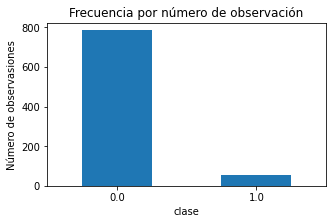

In [16]:
#@title Balance de clases { display-mode: "form" }
target = np.unique(y)
print("dimension del dataset: ",df_data.shape,"\n")
print(pd.value_counts(df_data['Biopsy'], sort = True))
plt.subplots(1,1,figsize=(5,3))
count_classes = pd.value_counts(df_data['Biopsy'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2),target)
plt.title("Frecuencia por número de observación")
plt.xlabel("clase")
plt.ylabel("Número de observasiones");

Predictor: GaussianNB
Score en test:  0.10714285714285714
Score en entrenamiento 0.10714285714285714


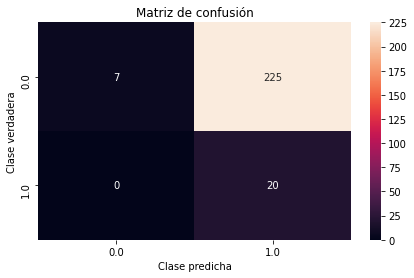

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       232
         1.0       0.08      1.00      0.15        20

    accuracy                           0.11       252
   macro avg       0.54      0.52      0.10       252
weighted avg       0.93      0.11      0.07       252




Predictor: DecisionTreeClassifier
Score en test:  0.9523809523809523
Score en entrenamiento 0.9523809523809523


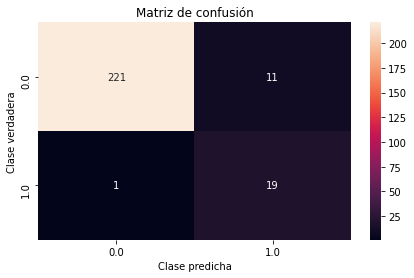

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       232
         1.0       0.63      0.95      0.76        20

    accuracy                           0.95       252
   macro avg       0.81      0.95      0.87       252
weighted avg       0.97      0.95      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9484126984126984
Score en entrenamiento 0.9484126984126984


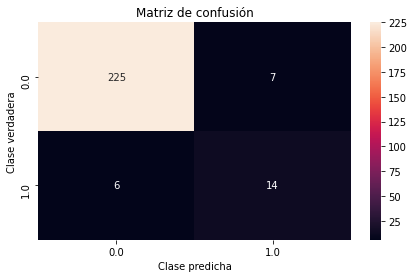

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       232
         1.0       0.67      0.70      0.68        20

    accuracy                           0.95       252
   macro avg       0.82      0.83      0.83       252
weighted avg       0.95      0.95      0.95       252




Predictor: SVC
Score en test:  0.9087301587301587
Score en entrenamiento 0.9087301587301587


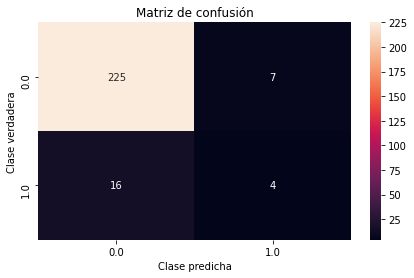

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       232
         1.0       0.36      0.20      0.26        20

    accuracy                           0.91       252
   macro avg       0.65      0.58      0.60       252
weighted avg       0.89      0.91      0.90       252






In [19]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain,ytrain,Xtest,ytest)
  l.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

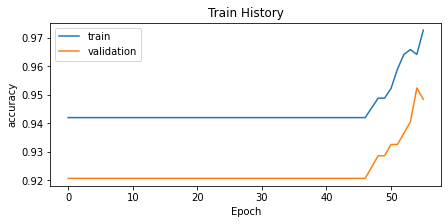

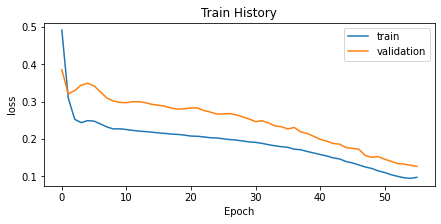

Test accuracy: 0.9484127163887024
 test_loss:  0.12633278965950012


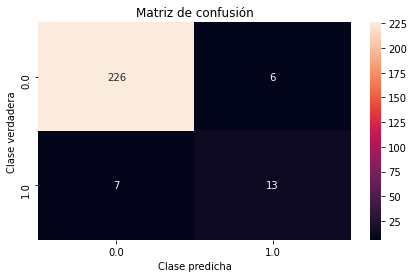

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       232
         1.0       0.68      0.65      0.67        20

    accuracy                           0.95       252
   macro avg       0.83      0.81      0.82       252
weighted avg       0.95      0.95      0.95       252



In [20]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain.values[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(Xtrain_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(Xtrain, y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(Xtest, y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l.append(mod)

In [21]:
base_df = pd.DataFrame(l)
base_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.090444,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.984642,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
2,RandomForestClassifier,0.991468,0.948413,0.948413,0.682927,0.969828,0.70,0.974026,0.666667,0.834914
3,SVC,0.901024,0.908730,0.908730,0.258065,0.969828,0.20,0.933610,0.363636,0.584914
4,DNN,0.972696,0.948413,0.948413,0.666667,0.974138,0.65,0.969957,0.684211,0.812069


## 6. Modelo final

### Se hace un Oversampling

Se hace un sobremuestreo en los datos de entrenamiento y se crean muestras artificiales para la clase minoritaria

In [22]:
Xtrain_s, ytrain_s = RandomOverSampler(random_state=33).fit_resample(Xtrain, ytrain.ravel())
print(sorted(Counter(ytrain_s).items()))

[(0.0, 552), (1.0, 552)]


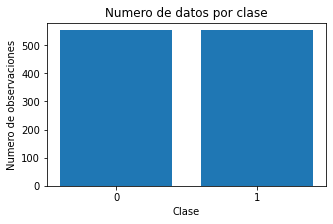

In [23]:
#@title Balance de clases  { display-mode: "form" }
plt.subplots(1,1,figsize=(5,3))
target= ['0', '1']
lista = [np.sum(ytrain_s==0),np.sum(ytrain_s==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: GaussianNB
Score en test:  0.10714285714285714
Score en entrenamiento 0.10714285714285714


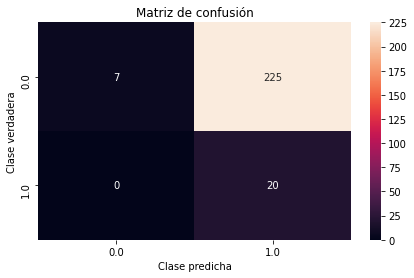

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       232
         1.0       0.08      1.00      0.15        20

    accuracy                           0.11       252
   macro avg       0.54      0.52      0.10       252
weighted avg       0.93      0.11      0.07       252




Predictor: DecisionTreeClassifier
Score en test:  0.9563492063492064
Score en entrenamiento 0.9563492063492064


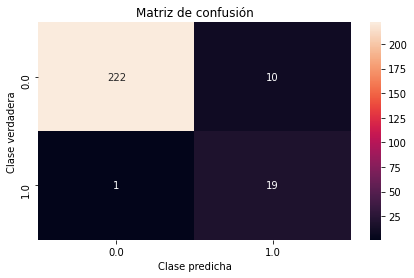

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.66      0.95      0.78        20

    accuracy                           0.96       252
   macro avg       0.83      0.95      0.88       252
weighted avg       0.97      0.96      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


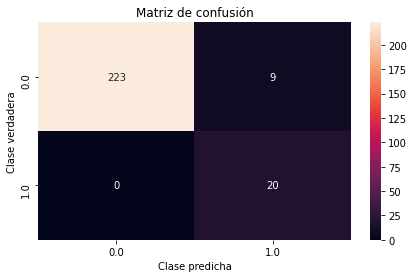

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252




Predictor: SVC
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


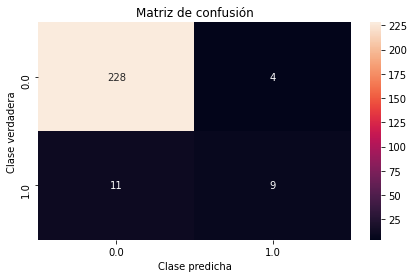

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       232
         1.0       0.69      0.45      0.55        20

    accuracy                           0.94       252
   macro avg       0.82      0.72      0.76       252
weighted avg       0.93      0.94      0.93       252






In [24]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain_s,ytrain_s,Xtest,ytest)
  l_final.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

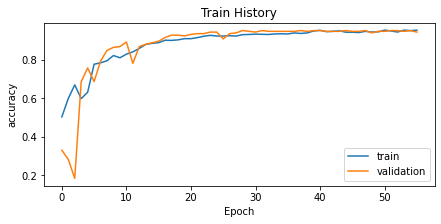

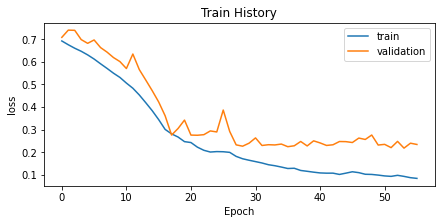

Test accuracy: 0.9444444179534912
 test_loss:  0.23406295478343964


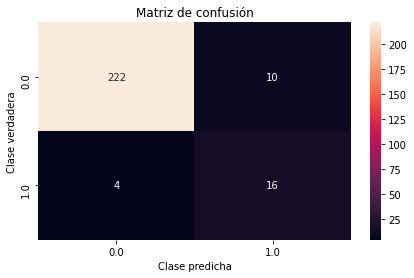

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       232
         1.0       0.62      0.80      0.70        20

    accuracy                           0.94       252
   macro avg       0.80      0.88      0.83       252
weighted avg       0.95      0.94      0.95       252



In [25]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain_s, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain_s[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(Xtrain_s_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain_s, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(Xtrain_s, y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(Xtest, y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l_final.append(mod)

In [27]:
oversampling_df = pd.DataFrame(l_final)
oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.517210,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.991848,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
2,RandomForestClassifier,0.960145,0.964286,0.964286,0.816327,0.961207,1.00,1.000000,0.689655,0.980603
3,SVC,0.739130,0.940476,0.940476,0.545455,0.982759,0.45,0.953975,0.692308,0.716379
4,DNN,0.956522,0.944444,0.944444,0.695652,0.956897,0.80,0.982301,0.615385,0.878448


### Seleccionamos las mejores características para los diferentes predictores

Hemos utilizado la técnica RFE para la selección de características.
Eliminación de características recursivas (RFE), como sugiere su título, elimina características de manera recursiva, crea un modelo utilizando los atributos restantes y calcula la precisión del modelo.
RFE puede calcular la combinación de atributos que contribuyen a la predicción de la variable (o clase) objetivo.
Las características se eligen en función de la puntuación de recall, es decir, qué conjunto de características dió la puntuación de recall más alta

In [ ]:
X1=X.drop(['Schiller','Citology','Hinselmann'],axis=1)

In [ ]:
for i in range(1,df_data.shape[1]):
    model = RFE(DecisionTreeClassifier(),i).fit(X1,y)
    print(X1.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X1),y,test_size=0.3,random_state=0)
    dt = DecisionTreeClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    reca = recall_score(y_test, y_pred, average=None)
    print('roc_auc',dt_recall)
    print('recall-0', reca[0])
    print('recall-1', reca[1])
    print('*'*100)

In [28]:
rfe_dt=['Age', 'First_sexual_intercourse','No_pregnancies', 'STDs_syphilis',
       'Dx_CIN', 'Schiller','Citology']
len(rfe_dt)

7

In [ ]:
for i in range(1,df_data.shape[1]):
    model = RFE(RandomForestClassifier(),i).fit(X1,y)
    print(X1.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X1),y,test_size=0.3,random_state=0)
    dt = RandomForestClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    reca = recall_score(y_test, y_pred, average=None)
    print('roc_auc',dt_recall)
    print('recall-0', reca[0])
    print('recall-1', reca[1])
    print('*'*100)

In [29]:
rfe_rf=['Age', 'First_sexual_intercourse',
  'No_pregnancies', 'STDs_number',
  'Hinselmann', 'Schiller', 'Citology']
len(rfe_rf)

7

In [30]:
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

rfe_dt_df_train = x_train_s[rfe_dt]
rfe_dt_df_test = x_test[rfe_dt]
rfe_rf_df_train = x_train_s[rfe_rf]
rfe_rf_df_test = x_test[rfe_rf]

B = [(rfe_dt_df_train,rfe_dt_df_test),(rfe_rf_df_train,rfe_rf_df_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.9563492063492064
Score en entrenamiento 0.9563492063492064


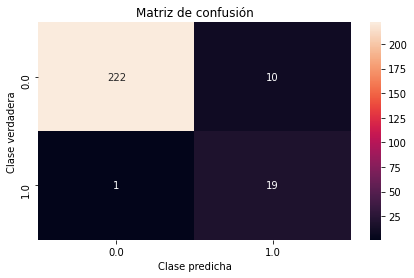

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.66      0.95      0.78        20

    accuracy                           0.96       252
   macro avg       0.83      0.95      0.88       252
weighted avg       0.97      0.96      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9563492063492064
Score en entrenamiento 0.9563492063492064


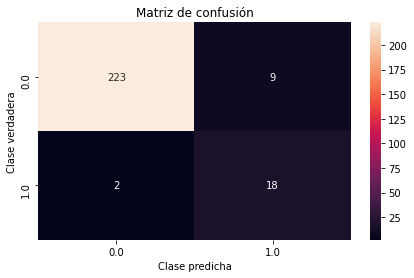

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       232
         1.0       0.67      0.90      0.77        20

    accuracy                           0.96       252
   macro avg       0.83      0.93      0.87       252
weighted avg       0.97      0.96      0.96       252






In [31]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final_BF=[]
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],ytrain_s,B[i][1],ytest)
  l_final_BF.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

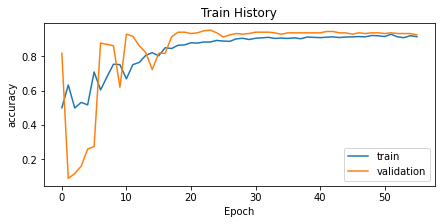

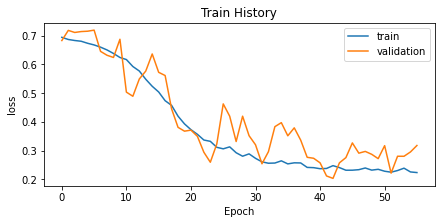

Test accuracy: 0.9246031641960144
 test_loss:  0.318217933177948


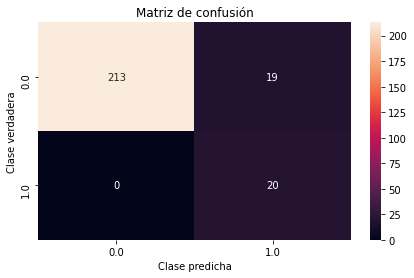

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       232
         1.0       0.51      1.00      0.68        20

    accuracy                           0.92       252
   macro avg       0.76      0.96      0.82       252
weighted avg       0.96      0.92      0.94       252



In [32]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain_s, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= B[0][0].values[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(B[0][0]_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(B[0][1]_pca, y_test_ohe))
train_history = model.fit(x=B[0][0], y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(B[0][1], y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(B[0][1], y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(B[0][1])
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(B[0][0], y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(B[0][1], y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l_final_BF.append(mod)

In [33]:
BF_oversampling_df = pd.DataFrame(l_final_BF)
BF_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.990942,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
1,RandomForestClassifier,0.975543,0.956349,0.956349,0.765957,0.961207,0.90,0.991111,0.666667,0.930603
2,DNN,0.926630,0.924603,0.924603,0.677966,0.918103,1.00,1.000000,0.512821,0.959052


### Ajuste de hiperparámetros


Se utilizó la validación cruzada de búsqueda de cuadrícula para árboles de decisión y la validación cruzada de búsqueda aleatoria para bosque aleatorio (GridSearchCV puede tomar más tiempo) para elegir los mejores valores de parámetro

In [34]:
tree = DecisionTreeClassifier()
tree_param = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],  
    'max_depth':[3,4,5,6,7],
    'max_features':['auto','log2','sqrt'],
    #'random_state':[123],
    'class_weight':['balanced',None]
}

grid = GridSearchCV(tree, tree_param, cv=10)
best_parameter_search = grid.fit(rfe_dt_df_train,y_train_s.values)
best_parameter_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'splitter': 'best'}

In [35]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators' : range(10,100,10),
    'max_depth' : range(2,10,1),
    'criterion' : ['gini','entropy'],
    'max_leaf_nodes' : range(2,10,1),
    'max_features' : ['auto','log2','sqrt'],
    'class_weight':['balanced',None]
}

grid = RandomizedSearchCV(rf, rf_params, cv=10)
best_parameter_search = grid.fit(rfe_rf_df_train,y_train_s.values)
best_parameter_search.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'log2',
 'max_leaf_nodes': 6,
 'n_estimators': 10}

Predictor: DecisionTreeClassifier
Score en test:  0.9523809523809523
Score en entrenamiento 0.9523809523809523


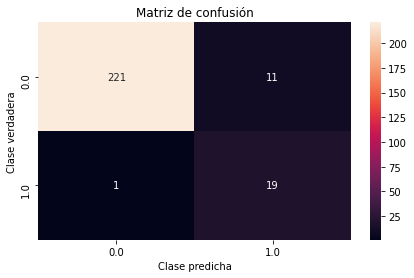

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       232
         1.0       0.63      0.95      0.76        20

    accuracy                           0.95       252
   macro avg       0.81      0.95      0.87       252
weighted avg       0.97      0.95      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9603174603174603
Score en entrenamiento 0.9603174603174603


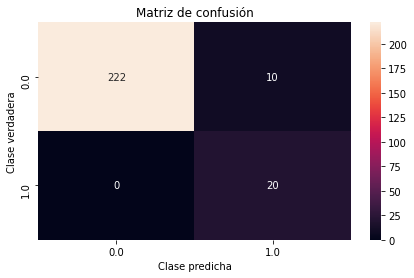

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.67      1.00      0.80        20

    accuracy                           0.96       252
   macro avg       0.83      0.98      0.89       252
weighted avg       0.97      0.96      0.96       252






In [36]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_hyper = []
#DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],ytrain_s,B[i][1],ytest)
  l_hyper.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [37]:
l_hyper.append(l_final_BF[2])

In [38]:
HBF_oversampling_df = pd.DataFrame(l_hyper)
HBF_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.990942,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
1,RandomForestClassifier,0.901268,0.960317,0.960317,0.800000,0.956897,1.00,1.000000,0.666667,0.978448
2,DNN,0.926630,0.924603,0.924603,0.677966,0.918103,1.00,1.000000,0.512821,0.959052


##Sólo con 	Schiller

In [39]:
rfe_shiller = ['Schiller']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_Shiller = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

Shiller_train = x_train_s[rfe_shiller]
Shiller_test = x_test[rfe_shiller]

B = [(Shiller_train,Shiller_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


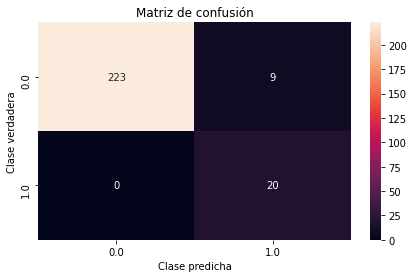

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


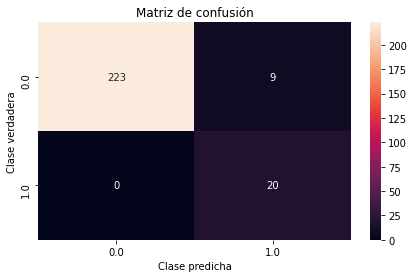

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252






In [40]:
#@title Pruebas con los clasificadores { display-mode: "form" }
shiller = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Shiller_train,y_train_Shiller,Shiller_test,ytest)
  shiller.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [ ]:
df_shiller = pd.DataFrame(shiller)
df_shiller

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.871377,0.964286,0.964286,0.816327,0.961207,1.0,1.0,0.689655,0.980603
1,RandomForestClassifier,0.871377,0.964286,0.964286,0.816327,0.961207,1.0,1.0,0.689655,0.980603


##Sólo con Hinselmann

In [41]:
rfe_Hinselmann = ['Hinselmann']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

Hinselmann_train = x_train_s[rfe_Hinselmann]
Hinselmann_test = x_test[rfe_Hinselmann]

Predictor: DecisionTreeClassifier
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


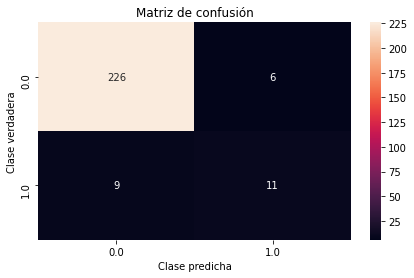

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       232
         1.0       0.65      0.55      0.59        20

    accuracy                           0.94       252
   macro avg       0.80      0.76      0.78       252
weighted avg       0.94      0.94      0.94       252




Predictor: RandomForestClassifier
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


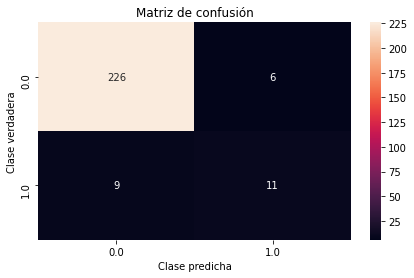

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       232
         1.0       0.65      0.55      0.59        20

    accuracy                           0.94       252
   macro avg       0.80      0.76      0.78       252
weighted avg       0.94      0.94      0.94       252






In [42]:
#@title Pruebas con los clasificadores { display-mode: "form" }
Hinselmann = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Hinselmann_train,y_train_s,Hinselmann_test,ytest)
  Hinselmann.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [43]:
df_Hinselmann = pd.DataFrame(Hinselmann)
df_Hinselmann

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.678442,0.940476,0.940476,0.594595,0.974138,0.55,0.961702,0.647059,0.762069
1,RandomForestClassifier,0.678442,0.940476,0.940476,0.594595,0.974138,0.55,0.961702,0.647059,0.762069


##Con 	Schiller y Hinselman

In [44]:
rfe_shi_hin = ['Schiller','Hinselmann']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_SH = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

SH_train = x_train_s[rfe_shi_hin]
SH_test = x_test[rfe_shi_hin]


Predictor: DecisionTreeClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


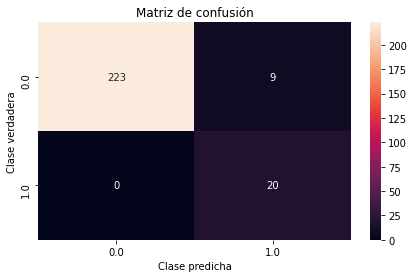

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


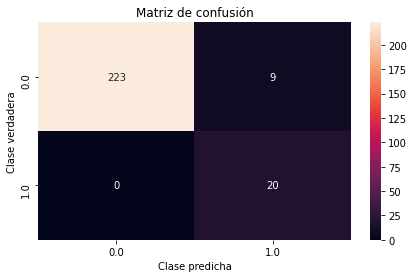

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252






In [45]:
#@title Pruebas con los clasificadores { display-mode: "form" }
shiller = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],SH_train,y_train_SH,SH_test,ytest)
  shiller.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [46]:
df_shiller = pd.DataFrame(shiller)
df_shiller

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.871377,0.964286,0.964286,0.816327,0.961207,1.0,1.0,0.689655,0.980603
1,RandomForestClassifier,0.871377,0.964286,0.964286,0.816327,0.961207,1.0,1.0,0.689655,0.980603


##Sin Hinselmann y Shiller

In [47]:
d1 = ['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'No_pregnancies', 'Smokes_yrs', 'Hormonal_Contraceptives_years',
       'IUD_years', 'STDs_HIV', 'Dx', 'Citology']
d2 = ['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
        'No_pregnancies', 'Smokes_yrs', 'Hormonal_Contraceptives_years',
        'IUD_years', 'Citology']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

dt_df_train = x_train_s[d1]
dt_df_test = x_test[d1]
rf_df_train = x_train_s[d2]
rf_df_test = x_test[d2]

B = [(dt_df_train,dt_df_test),(rf_df_train,rf_df_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.8849206349206349
Score en entrenamiento 0.8849206349206349


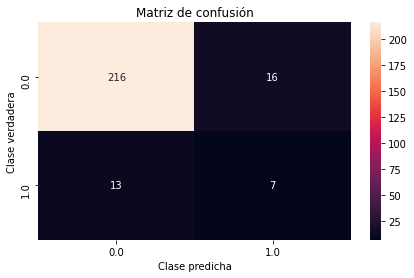

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       232
         1.0       0.30      0.35      0.33        20

    accuracy                           0.88       252
   macro avg       0.62      0.64      0.63       252
weighted avg       0.89      0.88      0.89       252




Predictor: RandomForestClassifier
Score en test:  0.8849206349206349
Score en entrenamiento 0.8849206349206349


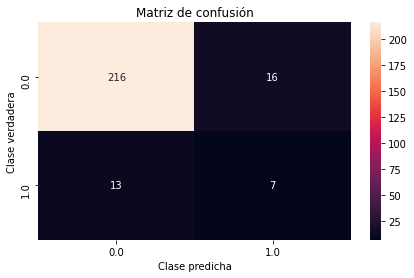

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       232
         1.0       0.30      0.35      0.33        20

    accuracy                           0.88       252
   macro avg       0.62      0.64      0.63       252
weighted avg       0.89      0.88      0.89       252






In [48]:
#@title Pruebas con los clasificadores { display-mode: "form" }
Hinselmann = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],y_train_s,B[i][1],ytest)
  Hinselmann.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [49]:
df_Hinselmann = pd.DataFrame(Hinselmann)
df_Hinselmann

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.868659,0.884921,0.884921,0.325581,0.931034,0.35,0.943231,0.304348,0.640517
1,RandomForestClassifier,0.788043,0.884921,0.884921,0.325581,0.931034,0.35,0.943231,0.304348,0.640517


##Sin Shiller

In [50]:
d1 = ['Age', 'First_sexual_intercourse', 'No_pregnancies',
        'Hormonal_Contraceptives_years', 'Hinselmann', 'Citology']

d2 = ['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'Hormonal_Contraceptives_years', 'Hinselmann', 'Citology']

x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

dt_df_train = x_train_s[d1]
dt_df_test = x_test[d1]
rf_df_train = x_train_s[d2]
rf_df_test = x_test[d2]

B = [(dt_df_train,dt_df_test),(rf_df_train,rf_df_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


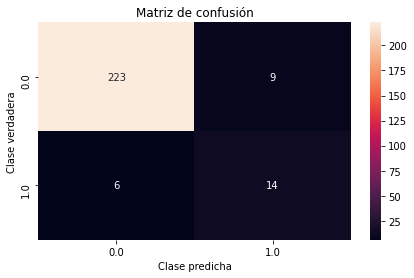

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       232
         1.0       0.61      0.70      0.65        20

    accuracy                           0.94       252
   macro avg       0.79      0.83      0.81       252
weighted avg       0.94      0.94      0.94       252




Predictor: RandomForestClassifier
Score en test:  0.9325396825396826
Score en entrenamiento 0.9325396825396826


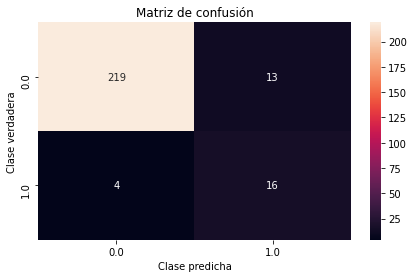

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       232
         1.0       0.55      0.80      0.65        20

    accuracy                           0.93       252
   macro avg       0.77      0.87      0.81       252
weighted avg       0.95      0.93      0.94       252






In [51]:
#@title Pruebas con los clasificadores { display-mode: "form" }
Hinselmann = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],y_train_s,B[i][1],ytest)
  Hinselmann.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [52]:
df_Hinselmann = pd.DataFrame(Hinselmann)
df_Hinselmann

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.825181,0.940476,0.940476,0.651163,0.961207,0.7,0.973799,0.608696,0.830603
1,RandomForestClassifier,0.798913,0.932540,0.932540,0.653061,0.943966,0.8,0.982063,0.551724,0.871983


##Análisis

Modelo base

In [53]:
base_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.090444,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.984642,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
2,RandomForestClassifier,0.991468,0.948413,0.948413,0.682927,0.969828,0.70,0.974026,0.666667,0.834914
3,SVC,0.901024,0.908730,0.908730,0.258065,0.969828,0.20,0.933610,0.363636,0.584914
4,DNN,0.972696,0.948413,0.948413,0.666667,0.974138,0.65,0.969957,0.684211,0.812069


Modelo con balance de clases

In [55]:
oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.517210,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.991848,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
2,RandomForestClassifier,0.960145,0.964286,0.964286,0.816327,0.961207,1.00,1.000000,0.689655,0.980603
3,SVC,0.739130,0.940476,0.940476,0.545455,0.982759,0.45,0.953975,0.692308,0.716379
4,DNN,0.956522,0.944444,0.944444,0.695652,0.956897,0.80,0.982301,0.615385,0.878448


Modelo con las mejores características y con balance de clases

In [56]:
BF_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.990942,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
1,RandomForestClassifier,0.975543,0.956349,0.956349,0.765957,0.961207,0.90,0.991111,0.666667,0.930603
2,DNN,0.926630,0.924603,0.924603,0.677966,0.918103,1.00,1.000000,0.512821,0.959052


Ajustando los hiperparámetros de los clasificadores

In [57]:
HBF_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.990942,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
1,RandomForestClassifier,0.901268,0.960317,0.960317,0.800000,0.956897,1.00,1.000000,0.666667,0.978448
2,DNN,0.926630,0.924603,0.924603,0.677966,0.918103,1.00,1.000000,0.512821,0.959052


In [58]:
print("Mejores Características DT: ",rfe_dt)
print("\nMejores Características RT: ",rfe_rf)

Mejores Características DT:  ['Age', 'First_sexual_intercourse', 'No_pregnancies', 'STDs_syphilis', 'Dx_CIN', 'Schiller', 'Citology']

Mejores Características RT:  ['Age', 'First_sexual_intercourse', 'No_pregnancies', 'STDs_number', 'Hinselmann', 'Schiller', 'Citology']


In [61]:
import eli5
from eli5.sklearn import PermutationImportance
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)

print('Características más importantes de DecisionTreeClassifier sin schiller' )
DT.fit(B[0][0],ytrain_s)
permumtation_impor = PermutationImportance(DT, random_state=2019).fit(B[0][1], ytest)
eli5.show_weights(permumtation_impor, feature_names = B[0][1].columns.tolist())

Características más importantes de DecisionTreeClassifier sin schiller


Weight,Feature
0.0675 ± 0.0142,Hinselmann
0.0270 ± 0.0551,Age
0.0238 ± 0.0219,First_sexual_intercourse
0.0151 ± 0.0117,No_pregnancies
0.0135 ± 0.0171,Citology
-0.0151 ± 0.0184,Hormonal_Contraceptives_years


In [62]:
print('Características más importantes de RandomForestClassifier sin schiller' )
RF.fit(B[1][0],ytrain_s)
permumtation_impor = PermutationImportance(RF, random_state=2019).fit(B[1][1], ytest)
eli5.show_weights(permumtation_impor, feature_names = B[1][1].columns.tolist())

Características más importantes de RandomForestClassifier sin schiller


Weight,Feature
0.0865 ± 0.0105,Hinselmann
0.0405 ± 0.0137,Citology
0.0016 ± 0.0039,First_sexual_intercourse
0.0016 ± 0.0039,No_of_sex_partner
0 ± 0.0000,Age
-0.0008 ± 0.0078,Hormonal_Contraceptives_years


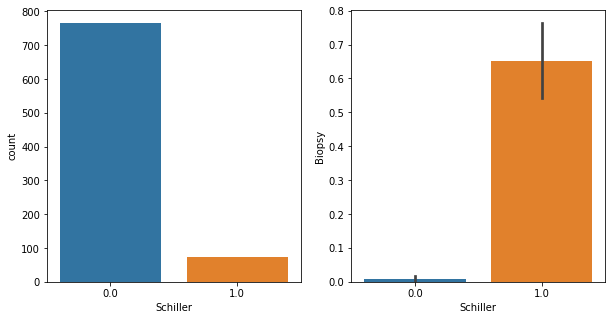

In [74]:
#@title Schiller { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Schiller', data=df_data, ax=axis1)
sns.barplot(x='Schiller', y='Biopsy', data=df_data, ax=axis3)

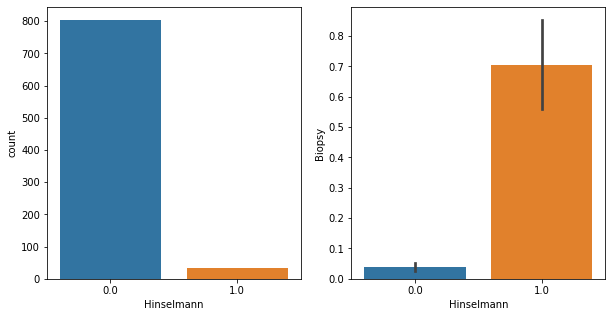

In [75]:
#@title Hinselmann { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Hinselmann', data=df_data, ax=axis1)
sns.barplot(x='Hinselmann', y='Biopsy', data=df_data, ax=axis3)

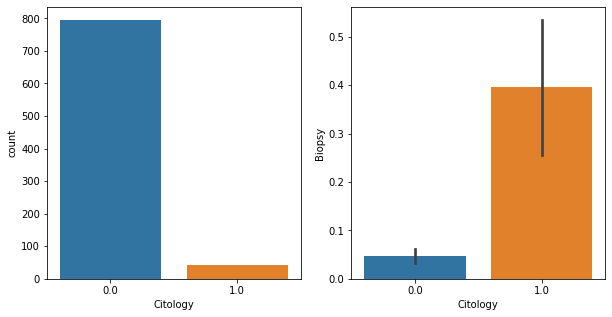

In [76]:
#@title Citology { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Citology', data=df_data, ax=axis1)
sns.barplot(x='Citology', y='Biopsy', data=df_data, ax=axis3)

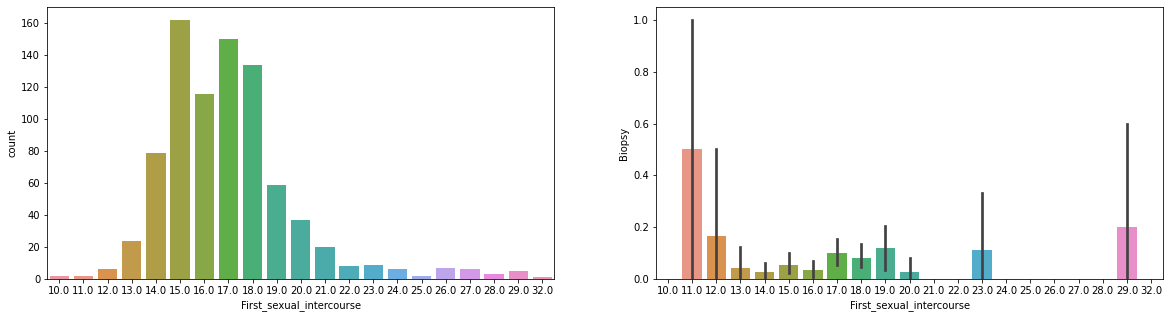

In [70]:
#@title Edad primera relación sexual { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='First_sexual_intercourse', data=df_data, ax=axis1)
#sns.countplot(x='Biopsy', data=df_data, ax=axis2)
sns.barplot(x='First_sexual_intercourse', y='Biopsy', data=df_data, ax=axis3)

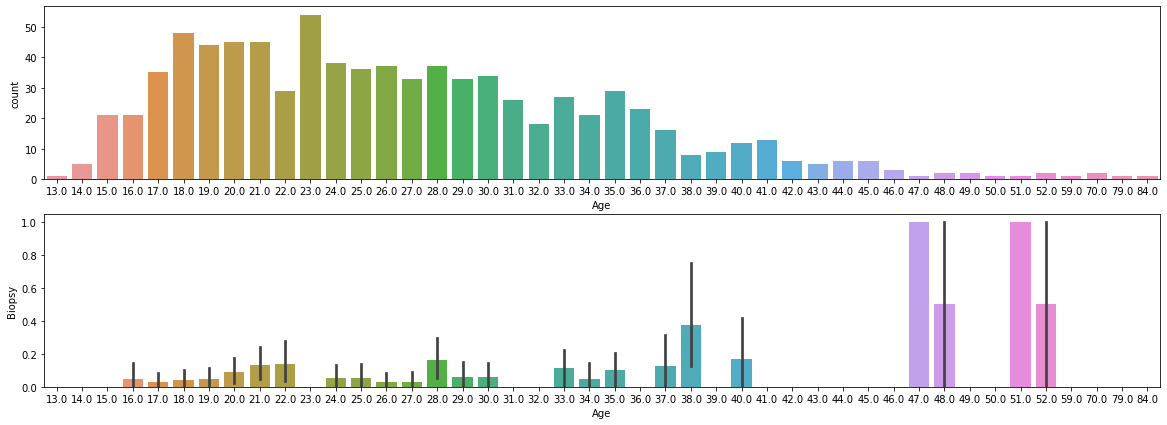

In [83]:
#@title Edad de la mujer { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(2,1,figsize=(20,7))
sns.countplot(x='Age', data=df_data, ax=axis1)
sns.barplot(x='Age', y='Biopsy', data=df_data, ax=axis3)

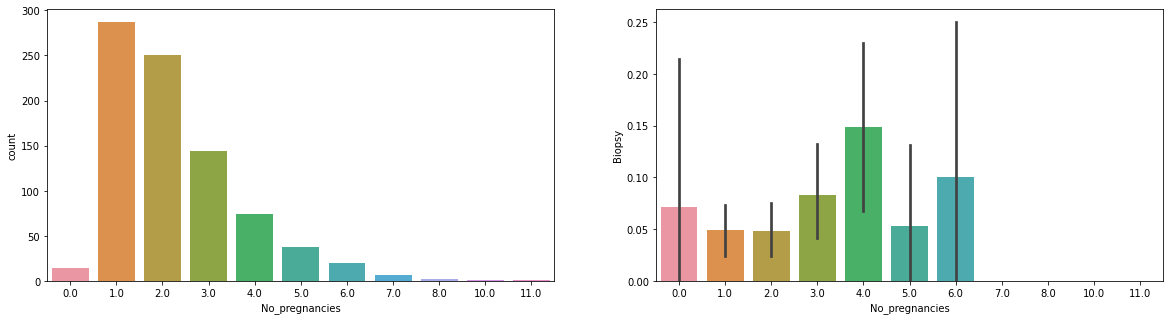

In [85]:
#@title Número de embarazos { display-mode: "form" }
fig, (axis1,axis3) = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='No_pregnancies', data=df_data, ax=axis1)
sns.barplot(x='No_pregnancies', y='Biopsy', data=df_data, ax=axis3)

<p align="justify">Podemos observar que las características más significantes para nuestros modelos se encuentran principalmente en la prueba de Hinselmann y la de Shiller, sin embargo también hay otras características como la citología que también son relevantes, esto además lo podemos corroborar con la matriz de correlación, en donde estas tres características son la más correlacionadas con la Biopsia, esto coincide en sentido común del conocimiento médico, además pudimos observar que al balancear nuestra clase minoritaria (1) nuestros algoritmos presentan un falso negativo y falso positivo realmente bajo, aunque lo realmente importante para nosotros es que el sistema pueda clasificar de una mejor manera nuestra clase (1) que hace referencia a los falsos negativos, ya que esto representa las mujeres que realmente necesitan la biopcia y el modelo predice que no la requiere.</p>